# Applied Data Science Capstone


This notebook will be mainly used for the capstone project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


# Data

## 1) The neighborhood data

 We scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [3]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [4]:
df_neigh = pd.read_html(table_str)[0]
df_neigh.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [5]:
df_neigh = df_neigh.drop(df_neigh[df_neigh.Borough == 'Not assigned'].index)

In [6]:
df_neigh.rename(columns = {"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"}, inplace = True)

In [7]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df_neigh['Neighborhood'].replace('Not assigned', df_neigh['Borough'], inplace=True)

In [8]:
#More than one neighborhood can exist in one postal code area.
df_neigh['Neighborhood'] = (df_neigh['Neighborhood'].replace('\/',',', regex=True)
                        .replace(' ,',',', regex=True) 
                        .astype(str))

In [9]:
df_neigh.head()

Postal Code           Borough                                 Neighborhood
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_neigh['Borough'].unique()),
        df_neigh.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


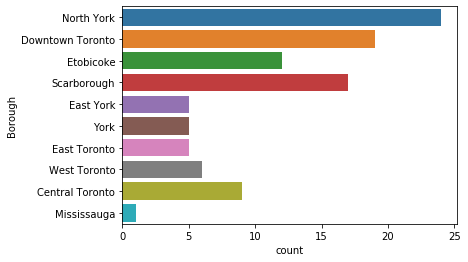

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.countplot(y='Borough', data=df_neigh)
plt.savefig('data3.png', bbox_inches='tight')

In [12]:
#df_grouped = df_neigh.groupby(['Borough','Postal Code'], as_index=False).agg(lambda x:','.join(x))
#df_grouped.head()

## 2) The latitude and the longitude coordinates of each neighborhood.

The geographical coordinates of each postal code:

In [13]:
file_name ='https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(file_name)
df_geo.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Now we merge  Geocoder and neighborhood dataframe:

In [14]:
df = pd.merge(df_neigh, df_geo, on='Postal Code')
df.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [15]:
df.drop(['Postal Code'], axis=1, inplace=True)
df.head()

Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

Use geopy library to get the latitude and longitude values of Toronto.

In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Toronto are 43.6534817, -79.3839347.


In [17]:
#Create list with the Boroughs (to be used later)
boroughs = df['Borough'].unique().tolist()
boroughs

['North York',
 'Downtown Toronto',
 'Etobicoke',
 'Scarborough',
 'East York',
 'York',
 'East Toronto',
 'West Toronto',
 'Central Toronto',
 'Mississauga']

In [18]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

Create a map of Toronto with neighborhoods superimposed on top.

In [19]:

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## 3) Define Foursquare Credentials and Version

To get a list of all the Venues in Toronto which included Parks, Schools, Café Shops, Asian Restaurants etc. Getting this data was crucial to analyzing the number of vegetrian Restaurants all over Toronto. 

In [20]:
CLIENT_ID = '1TWWHYOVWCGVA3FVLBNQEMRNGH2YTRWSBZCXJ4IHWQLRXK2X' # your Foursquare ID
CLIENT_SECRET = 'UHK5JCQJM4KH23EEPBCBSLKGIGQPVTQBHMZUUHPQ0FXKD2FS' # your Foursquare Secret
VERSION = '20201210' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1TWWHYOVWCGVA3FVLBNQEMRNGH2YTRWSBZCXJ4IHWQLRXK2X
CLIENT_SECRET:UHK5JCQJM4KH23EEPBCBSLKGIGQPVTQBHMZUUHPQ0FXKD2FS


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'ID',
                  'Name',   
                  'Venue Latitude', 
                  'Venue Longitude',    
                  'Venue Category']
    
    return(nearby_venues)

# Vegetarian Restaurants in Toronto?

In [22]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [23]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2  Victoria Village              43.725882              -79.315572   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                         ID                    Name  Venue Latitude  \
0  4e8d9dcdd5fbbbb6b3003c7b         Brookbanks Park       43.751976   
1  4cb11e2075ebb60cd1c4caad           Variety Store       43.751974   
2  4c633acb86b6be9a61268e34  Victoria Village Arena       43.723481   
3  4bbe904a85fbb713420d7167             Tim Hortons       43.725517   
4  4f3ecce6e4b0587016b6f30d               Portugril       43.725819   

   Venue Longitude         Venue Category  
0       -79.332140                   Park  
1       -79.333114      Food & Drink Shop  
2       -79.315635           Hockey Arena  
3       -79.313103            Coffee Shop  
4       -79.312785  Portuguese Restaurant

## Namber of Vegetarian restaurant in each neighborhood

In [24]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      22   
Berczy Park                                                            55   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     16   
CN Tower, King and Spadina, Railway Lands, Harb...                     16   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  13   
Cedarbrae                                                               8   
Central Bay Street                                                     68   
Christie                                                               16   
Church and Wellesley                                                   75   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             33   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        5   
Don Mills                                                              23   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview                                                              16   
Dufferin, Dovercourt Village                                           13   
East Toronto, Broadview North (Old East York)                           3   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           70   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          25   
Hillcrest Village                                                       5   
Humber Summit                                                           2   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      5   
India Bazaar, The Beaches West                                         19   
Kennedy Park, Ionview, East Birchmount Park                             4   
Kensington Market, Chinatown, Grange Park                              74   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       13   
Lawrence Park                                                           3   
Leaside                                                                33   
Little Portugal, Trinity                                               45   
Malvern, Rouge                                                          1   
Milliken, Agincourt North, Steeles East, L'Amor.

 How many unique venues are there?¶

In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


In [26]:
"Vegetarian / Vegan Restaurant" in toronto_venues['Venue Category'].unique()

True

### Now we will analyze each neighborhood

In [27]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2141, 274)


Neighborhoods  Accessories Store  Afghan Restaurant  Airport  \
0         Parkwoods                  0                  0        0   
1         Parkwoods                  0                  0        0   
2  Victoria Village                  0                  0        0   
3  Victoria Village                  0                  0        0   
4  Victoria Village                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0              0          0           0           0       0   
1            0              0          0           0           0       0   
2            0              0          0           0           0       0   
3            0              0          0           0           0       0   
4            0              0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0       0              0          0         0                     0   
1       0              0          0         0                     0   
2       0              0          0         0                     0   
3       0              0          0         0                     0   
4       0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0               0        0            0                0         0   
1               0        0            0                0         0   
2               0        0            0                0         0   
3               0        0            0                0         0   
4               0        0            0                0    

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 274)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.045455   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0          0.0         0.0                  0.0   
1           0.0       0.0          0.0         0.0                  0.0   
2           0.0       0.0          0.0         0.0                  0.0   
3           0.0       0.0          0.0         0.0                  0.0   
4           0.0       0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0               0.0                 0.0          0.0            0.0   
1               0.0                 0.0          0.0            0.0   
2               0.0                 0.0          0.0            0.0   
3               0.0                 0.0          0.0            0.0   
4               0.0                 0.0          0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
1        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
2        0.0         0.0         0.0     0.0  0.095238  0.0             0.0   
3        0.0         0.0         0.0     0.0  0.250000  0.0             0.0   
4        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   

   Baseball Stadium  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  \
0         0.0                 0.0        0.0     0.0            0.0   
1         0.0                 0.0        0.0     0.0            0.0   
2         0.0                 0.0        0.0     0.0            0.0   
3         0.0                 0.0        0.0     0.0            0.0   
4         0.0                 0.0        0.0     0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0             0.2      0.0   
1        0.0       0.0                   0.0             0.0      0.0   
2        0.0       0.0                   0.0             0.0      0.0   
3        0.0       0.0                   0.0             0.0      0.0   
4        0.0       0.0                   0.0             0.0      0.0   

   Bridal Shop  Bubble Tea Shop  Building  Burger 

In [29]:
frequency_Veg = to_grouped[["Neighborhoods","Vegetarian / Vegan Restaurant"]]
frequency_Veg

Neighborhoods  \
0                                           Agincourt   
1                              Alderwood, Long Branch   
2     Bathurst Manor, Wilson Heights, Downsview North   
3                                     Bayview Village   
4                   Bedford Park, Lawrence Manor East   
5                                         Berczy Park   
6                         Birch Cliff, Cliffside West   
7        Brockton, Parkdale Village, Exhibition Place   
8   Business reply mail Processing Centre, South C...   
9   CN Tower, King and Spadina, Railway Lands, Har...   
10                                Caledonia-Fairbanks   
11              Canada Post Gateway Processing Centre   
12                                          Cedarbrae   
13                                 Central Bay Street   
14                                           Christie   
15                               Church and Wellesley   
16            Clarks Corners, Tam O'Shanter, Sullivan   
17    Cliffside, Cliffcrest, Scarborough Village West   
18                     Commerce Court, Victoria Hotel   
19                                         Davisville   
20                                   Davisville North   
21   Del Ray, Mount Dennis, Keelsdale and Silverthorn   
22                                          Don Mills   
23  Dorset Park, Wexford Heights, Scarborough Town...   
24                                          Downsview   
25                       Dufferin, Dovercourt Village   
26      East Toronto, Broadview North (Old East York)   
27  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
28                       Fairview, Henry Farm, Oriole   
29             First Canadian Place, Underground city   
30    Forest Hill North & West, Forest Hill Road Park   
31                           Garden District, Ryerson   
32                                          Glencairn   
33                    Golden Mile, Clairlea, Oakridge   
34                  Guildwood, Morningside, West Hill   
35  Harbourfront East, Union Station, Toronto Islands   
36                      High Park, The Junction South   
37                                  Hillcrest Village   
38                                      Humber Summit   
39                                   Humberlea, Emery   
40                                 Humewood-Cedarvale   
41                     India Bazaar, The Beaches West   
42        Kennedy Park, Ionview, East Birchmount Park   
43          Kensington Market, Chinatown, Grange Park   
44  Kingsview Village, St. Phillips, Martin Grove ...   
45                   Lawrence Manor, Lawrence Heights   
46                                      Lawrence Park   
47                                            Leaside   
48                           Little Portugal, Trinity   
49                                     Malvern, Rouge   
50  Milliken, Agincourt North, Steeles East, L'Amo...   
51  Mimico NW, The Queensway West, South of Bloor,...   
52                        Moore Park, Summerhill East   
53       New Toronto, Mimico South, Humber Bay Shores   
54           North Park, Maple Leaf Park, Upwood Park   
55                  North Toronto West, Lawrence Park   
56                Northwest, West Humber - Clairville   
57                    Northwood Park, York University   
58  Old Mill South, King's Mill Park, Sunnylea, Hu...   
59                             Parkdale, Roncesvalles   
60                    Parkview Hill, Woodbine Gardens   
61                                          Parkwoods   
62        Queen's Park, Ontario Provincial Government   
63                          Regent Park, Harbourfront   
64                           Richmond, Adelaide, King   
65                                           Rosedale   
66                                           Roselawn   
67             Rouge Hill, Port Union, Highland Creek   
68                                 Runnymede, Swansea   
69                      Runnymede, The Junction No

In [30]:
frequency_Veg = frequency_Veg.rename(columns={'Neighborhoods':'Neighborhood'})

## Rating  study

In [31]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [32]:
toronto_detail= toronto_venues[toronto_venues['Venue Category']=="Vegetarian / Vegan Restaurant"]
toronto_detail.head(2)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
284  St. James Town              43.651494              -79.375418   
361     Berczy Park              43.644771              -79.373306   

                           ID            Name  Venue Latitude  \
284  5b5bca904aa3f8002c97f85d  Fresh On Front       43.647815   
361  5b5bca904aa3f8002c97f85d  Fresh On Front       43.647815   

     Venue Longitude                 Venue Category  
284       -79.374453  Vegetarian / Vegan Restaurant  
361       -79.374453  Vegetarian / Vegan Restaurant

In [33]:
toronto_detail.drop(['Neighborhood Latitude', 
                  'Neighborhood Longitude',  
                  'Venue Latitude', 
                  'Venue Longitude',    
                  'Venue Category'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
# prepare neighborhood list that contains indian resturants
column_names=['Neighborhood', 'ID','Name','Likes','Rating','Tips']
toronto_detail_ny=pd.DataFrame(columns=column_names)
count=1


for row in toronto_detail.values.tolist():
    Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(toronto_detail),')','processed')
    toronto_detail_ny = toronto_detail_ny.append({'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID            Name  Likes  Rating  Tips
0  5b5bca904aa3f8002c97f85d  Fresh On Front     11     8.5     3
( 1 / 16 ) processed
                         ID            Name  Likes  Rating  Tips
0  5b5bca904aa3f8002c97f85d  Fresh On Front     11     8.5     3
( 2 / 16 ) processed
                         ID              Name  Likes  Rating  Tips
0  4aeb711ef964a52017c221e3  Vegetarian Haven     58     8.7    31
( 3 / 16 ) processed
                         ID       Name  Likes  Rating  Tips
0  5aff06ca6e4650002cc6286b  Rosalinda     29     8.3     6
( 4 / 16 ) processed
                         ID           Name  Likes  Rating  Tips
0  5481b06c498ee191fa045a00  Kupfert & Kim      9     7.2     1
( 5 / 16 ) processed
                         ID    Name  Likes  Rating  Tips
0  54835826498ee8517125b280  Veghed      9     8.0     5
( 6 / 16 ) processed
                         ID       Name  Likes  Rating  Tips
0  5aff06ca6e4650002cc6286b  Rosalinda     29     8.3     

In [35]:
toronto_detail_ny

Neighborhood  \
0                                      St. James Town   
1                                         Berczy Park   
2                                  Central Bay Street   
3                            Richmond, Adelaide, King   
4   Harbourfront East, Union Station, Toronto Islands   
5                            Little Portugal, Trinity   
6            Toronto Dominion Centre, Design Exchange   
7                      Commerce Court, Victoria Hotel   
8                      Commerce Court, Victoria Hotel   
9                                  Runnymede, Swansea   
10          Kensington Market, Chinatown, Grange Park   
11          Kensington Market, Chinatown, Grange Park   
12          Kensington Market, Chinatown, Grange Park   
13          Kensington Market, Chinatown, Grange Park   
14                                     Stn A PO Boxes   
15             First Canadian Place, Underground city   

                          ID                          Name Likes  Rating Tips  
0   5b5bca904aa3f8002c97f85d                Fresh On Front    11     8.5    3  
1   5b5bca904aa3f8002c97f85d                Fresh On Front    11     8.5    3  
2   4aeb711ef964a52017c221e3              Vegetarian Haven    58     8.7   31  
3   5aff06ca6e4650002cc6286b                     Rosalinda    29     8.3    6  
4   5481b06c498ee191fa045a00                 Kupfert & Kim     9     7.2    1  
5   54835826498ee8517125b280                        Veghed     9     8.0    5  
6   5aff06ca6e4650002cc6286b                     Rosalinda    29     8.3    6  
7   5b5bca904aa3f8002c97f85d                Fresh On Front    11     8.5    3  
8   5aff06ca6e4650002cc6286b                     Rosalinda    29     8.3    6  
9   5824a5305309361c4ad317de                          Awai    11     6.9    5  
10  4b2d2ab2f964a52007d024e3                      Hibiscus    89     8.6   41  
11  4ad7e7acf964a520f40f21e3               Urban Herbivore    51     8.4   30  
12  4ae4e982f964a5205d9f21e3           Buddha's Vegetarian    29     7.7   26  
13  4cb79089dd41a35d6a2fd4a0  Greens Vegetarian Restaurant    23     7.1   19  
14  5b5bca904aa3f8002c97f85d                Fresh On Front    11     8.5    3  
15  5aff06ca6e4650002cc6286b                     Rosalinda    29     8.3    6

In [36]:
toronto_detail_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  16 non-null     object 
 1   ID            16 non-null     object 
 2   Name          16 non-null     object 
 3   Likes         16 non-null     object 
 4   Rating        16 non-null     float64
 5   Tips          16 non-null     object 
dtypes: float64(1), object(5)
memory usage: 896.0+ bytes


In [37]:
toronto_detail_ny = toronto_detail_ny.astype({ 'Likes': float, 'Tips': float })
toronto_detail_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  16 non-null     object 
 1   ID            16 non-null     object 
 2   Name          16 non-null     object 
 3   Likes         16 non-null     float64
 4   Rating        16 non-null     float64
 5   Tips          16 non-null     float64
dtypes: float64(3), object(3)
memory usage: 896.0+ bytes


### Average rating of all the restaurants 


In [38]:
rating_Veg=toronto_detail_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
rating_Veg.columns=['Neighborhood','Average Rating']

In [39]:
rating_Veg.sort_values(['Average Rating'],ascending=False)

Neighborhood  Average Rating
1                                  Central Bay Street            8.70
0                                         Berczy Park            8.50
9                                      St. James Town            8.50
10                                     Stn A PO Boxes            8.50
2                      Commerce Court, Victoria Hotel            8.40
3              First Canadian Place, Underground city            8.30
7                            Richmond, Adelaide, King            8.30
11           Toronto Dominion Centre, Design Exchange            8.30
6                            Little Portugal, Trinity            8.00
5           Kensington Market, Chinatown, Grange Park            7.95
4   Harbourfront East, Union Station, Toronto Islands            7.20
8                                  Runnymede, Swansea            6.90

In [40]:
#Toronto_Veg = pd.merge(rating_Veg,frequency_Veg, on='Neighborhood')
#Toronto_Veg.sort_values(["Vegetarian / Vegan Restaurant"], inplace=True)
#Toronto_Veg.head()

##  Cluster the neighborhoods in Toronto

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = frequency_Veg.drop(['Neighborhood'], axis=1)

In [42]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

In [43]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [44]:
scores = [get_inertia(x) for x in range(2, 10)]

Text(0, 0.5, 'Error')

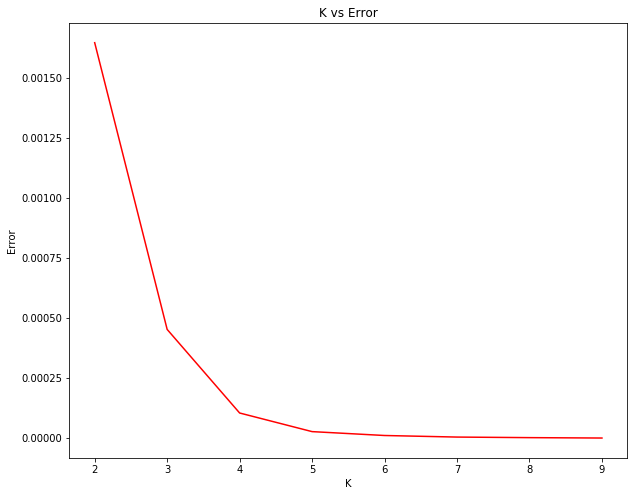

In [45]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 10), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 10))
plt.xlabel("K")
plt.ylabel("Error")

In [46]:
import yellowbrick
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

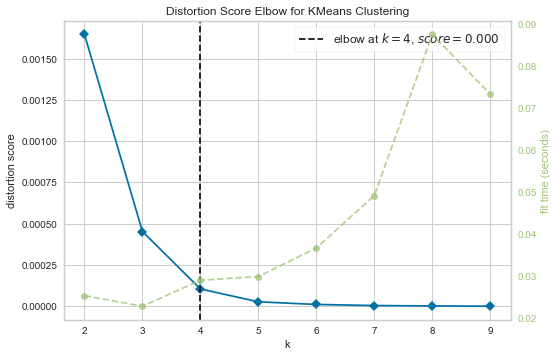

In [47]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)        # Fit the data to the visualizer

plt.savefig('data6.png', bbox_inches='tight')
visualizer.show()

In [48]:
kclusters = 4

toronto_grouped_clustering = frequency_Veg.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = frequency_Veg.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [50]:
to_merged.head()

Neighborhood  \
0                                        Agincourt   
1                           Alderwood, Long Branch   
2  Bathurst Manor, Wilson Heights, Downsview North   
3                                  Bayview Village   
4                Bedford Park, Lawrence Manor East   

   Vegetarian / Vegan Restaurant  Cluster Labels  
0                            0.0               0  
1                            0.0               0  
2                            0.0               0  
3                            0.0               0  
4                            0.0               0

In [51]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2141, 10)


Neighborhood  Vegetarian / Vegan Restaurant  Cluster Labels  \
0    Agincourt                            0.0               0   
0    Agincourt                            0.0               0   
0    Agincourt                            0.0               0   
0    Agincourt                            0.0               0   
0    Agincourt                            0.0               0   

   Neighborhood Latitude  Neighborhood Longitude                        ID  \
0                43.7942              -79.262029  4e3451fcd4c063434821c41e   
0                43.7942              -79.262029  4b50b100f964a520b72d27e3   
0                43.7942              -79.262029  4cf9c1297f2db1f7bc7823d4   
0                43.7942              -79.262029  4d0008a44f56b60c39b09f37   
0                43.7942              -79.262029  4af71437f964a520940522e3   

                          Name  Venue Latitude  Venue Longitude  \
0  Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                El Pulgarcito       43.792648       -79.259208   
0                     Twilight       43.791999       -79.258584   
0                       Mark's       43.791179       -79.259714   
0              Commander Arena       43.794867       -79.267989   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0             Clothing Store  
0               Skating Rink

In [52]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2141, 10)


Neighborhood  \
0                                           Agincourt   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
50  Milliken, Agincourt North, Steeles East, L'Amo...   
50  Milliken, Agincourt North, Steeles East, L'Amo...   
50  Milliken, Agincourt North, Steeles East, L'Amo...   
50  Milliken, Agincourt North, Steeles East, L'Amo...   
49                                     Malvern, Rouge   
47                                            Leaside   
47                                            Leaside   
47                                            Leaside   
47                                            Leaside   
47                                            Leaside   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
54           North Park, Maple Leaf Park, Upwood Park   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
47                                            Leaside   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
53       New Toronto, Mimico South, Humber Bay Shores   
52                        Moore Park, Summerhill East   
52                        Moore Park, Summerhill East   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
51  Mimico NW, The Queensway West, South of Bloor,...   
53       New Toronto, Mimico South, Humber Bay Shores   
54           North Park, Maple Leaf Park, Upwood Park   
47                                            Leaside   
47                                            Leaside   
46                                      Lawrence Park   
46                                      Lawrence Park   
46                                      Lawrence Park   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
45                   Lawrence Manor, Lawrence Heights   
44  Kingsview Village, St. Phillips, Martin Grove ...   
44  Kingsview Village, St. Phillips, Martin Grove ...   
44  Kingsview Village, St. Phillips, Martin Grove ...   
47                                            Leaside   
47                                            Leaside   
47                                            Leasi

In [53]:
to_merged['Venue Category'].value_counts()['Vegetarian / Vegan Restaurant']

16

We see that there are a total of 16 locations with Vegetarian / Vegan Restaurant Restaurants in Toronto
We will create a new dataframe with the Neighborhood and Vegetarian / Vegan Restaurant Restaurants

In [54]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)



# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(to_merged['Neighborhood Latitude'], 
                                  to_merged['Neighborhood Longitude'], 
                                  to_merged['Neighborhood'], 
                                  to_merged['Cluster Labels']):
    label = '{}, {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_clusters)
       
map_clusters

## How many Neighborhoods per Cluster?¶

In [56]:
frequency_Veg["Cluster Labels"] = kmeans.labels_
frequency_Veg.head()

Neighborhood  \
0                                        Agincourt   
1                           Alderwood, Long Branch   
2  Bathurst Manor, Wilson Heights, Downsview North   
3                                  Bayview Village   
4                Bedford Park, Lawrence Manor East   

   Vegetarian / Vegan Restaurant  Cluster Labels  
0                            0.0               0  
1                            0.0               0  
2                            0.0               0  
3                            0.0               0  
4                            0.0               0

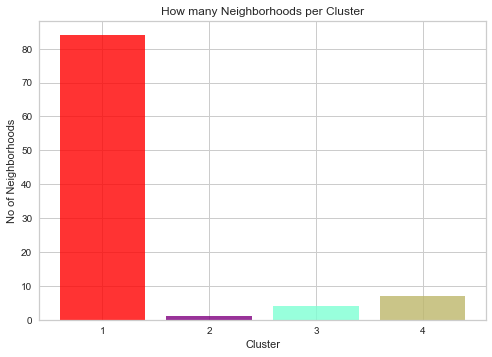

In [57]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = frequency_Veg['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.savefig('data8.png', bbox_inches='tight')


plt.show()

In [58]:
# How many neighborhoods in each cluster
frequency_Veg['Cluster Labels'].value_counts()

0    84
3     7
2     4
1     1
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster¶


In [59]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                                 Neighborhood
0        North York                                    Parkwoods
1        North York                             Victoria Village
2  Downtown Toronto                    Regent Park, Harbourfront
3        North York             Lawrence Manor, Lawrence Heights
4  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [60]:
# Red 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0           North York                                          Parkwoods   
1           North York                                          Parkwoods   
2           North York                                   Victoria Village   
3           North York                                   Victoria Village   
4           North York                                   Victoria Village   
5           North York                                   Victoria Village   
6           North York                                   Victoria Village   
7           North York                                   Victoria Village   
8     Downtown Toronto                          Regent Park, Harbourfront   
9     Downtown Toronto                          Regent Park, Harbourfront   
10    Downtown Toronto                          Regent Park, Harbourfront   
11    Downtown Toronto                          Regent Park, Harbourfront   
12    Downtown Toronto                          Regent Park, Harbourfront   
13    Downtown Toronto                          Regent Park, Harbourfront   
14    Downtown Toronto                          Regent Park, Harbourfront   
15    Downtown Toronto                          Regent Park, Harbourfront   
16    Downtown Toronto                          Regent Park, Harbourfront   
17    Downtown Toronto                          Regent Park, Harbourfront   
18    Downtown Toronto                          Regent Park, Harbourfront   
19    Downtown Toronto                          Regent Park, Harbourfront   
20    Downtown Toronto                          Regent Park, Harbourfront   
21    Downtown Toronto                          Regent Park, Harbourfront   
22    Downtown Toronto                          Regent Park, Harbourfront   
23    Downtown Toronto                          Regent Park, Harbourfront   
24    Downtown Toronto                          Regent Park, Harbourfront   
25    Downtown Toronto                          Regent Park, Harbourfront   
26    Downtown Toronto                          Regent Park, Harbourfront   
27    Downtown Toronto                          Regent Park, Harbourfront   
28    Downtown Toronto                          Regent Park, Harbourfront   
29    Downtown Toronto                          Regent Park, Harbourfront   
30    Downtown Toronto                          Regent Park, Harbourfront   
31    Downtown Toronto                          Regent Park, Harbourfront   
32    Downtown Toronto                          Regent Park, Harbourfront   
33    Downtown Toronto                          Regent Park, Harbourfront   
34    Downtown Toronto                          Regent Park, Harbourfront   
35    Downtown Toronto                          Regent Park, Harbourfront   
36    Downtown Toronto                          Regent Park, Harbourfront   
37    Downtown Toronto                          Regent Park, Harbourfront   
38    Downtown Toronto                          Regent Park, Harbourfront   
39    Downtown Toronto                          Regent Park, Harbourfront   
40    Downtown Toronto                          Regent Park, Harbourfront   
41    Downtown Toronto                          Regent Park, Harbourfront   
42    Downtown Toronto                          Regent Park, Harbourfront   
43    Downtown Toronto                          Regent Park, Harbourfront   
44    Downtown Toronto                          Regent Park, Harbourfront   
45    Downtown Toronto                          Regent Park, Harbourfront   
46    Downtown Toronto                          Regent Park, Harbourfront   
47    Downtown Toronto                          Regent Park, Harbourfront   
48    Downtown Toronto                          Regent Park, Harbourfront   
49    Downtown Toronto                          Regent Park, Harbourfront   
50    Downtown Toronto                          Regent Park, Harbourfront   
51    Downt

In [61]:
df_cluster2['Borough'].value_counts()

NameError: name 'df_cluster2' is not defined

In [ ]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

In [ ]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

In [ ]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

In [ ]:
clusters_mean = [df_cluster1['Vegetarian / Vegan Restaurant'].mean(),df_cluster2['Vegetarian / Vegan Restaurant'].mean(),df_cluster3['Vegetarian / Vegan Restaurant'].mean(),
                 df_cluster4['Vegetarian / Vegan Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Vegetarian  Restaurants per Cluster')


plt.savefig('data9.png', bbox_inches='tight')


plt.show()